<a href="https://colab.research.google.com/github/divy-arun-mav/handwriting-Recognition/blob/main/handwritingRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# collecting data
!wget -q https://git.io/J0fjL -O IAM_Words.zip
!unzip -qq IAM_Words.zip
!
!mkdir data
!mkdir data/words
!tar -xf IAM_Words/words.tgz -C data/words
!mv IAM_Words/words.txt data

In [21]:
!head -20 data/words.txt

#--- words.txt ---------------------------------------------------------------#
#
# iam database word information
#
# format: a01-000u-00-00 ok 154 1 408 768 27 51 AT A
#

plt.show()

Next steps:
Colab paid products - Cancel contracts here
#     a01-000u-00-00  -> word id for line 00 in form a01-000u
#     ok              -> result of word segmentation
#                            ok: word was correctly
#                            er: segmentation of word can be bad
#
#     154             -> graylevel to binarize the line containing this word
#     1               -> number of components for this word
#     408 768 27 51   -> bounding box around this word in x,y,w,h format
#     AT              -> the grammatical tag for this word, see the


In [7]:
from tensorflow.keras.layers import StringLookup
from tensorflow import keras
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)
tf.random.set_seed(42)

In [8]:
base_path = "data"
words_list = []

words = open(f"{base_path}/words.txt", "r").readlines()
for line in words:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":
        words_list.append(line)

len(words_list)
np.random.shuffle(words_list)

In [9]:
print(words_list[0:20])

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure\n', 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he\n', 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during\n', 'm01-000-07-00 ok 196 339 1998 75 107 INO of\n', 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty\n', 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy\n', 'n03-082-04-03 ok 165 992 1414 118 135 NN boy\n', 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The\n', 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and\n', 'f04-024-01-06 ok 183 1104 981 60 70 IN in\n', 'g06-050k-00-07 ok 156 1842 717 85 76 PP$ his\n', 'm01-100-01-06 ok 185 1459 880 177 131 JJ flying\n', 'n02-033-04-01 ok 149 940 1486 353 85 VBD presented\n', 'p03-047-00-01 ok 191 393 739 127 80 UH No\n', 'g06-011e-08-00 ok 154 386 2190 70 44 CS as\n', 'p02-000-00-02 ok 182 752 727 97 85 AP few\n', 'c01-009-08-03 ok 182 1387 2363 170 81 NN work\n', 'c04-156-01-04 ok 175 989 912 65 142 INO of\n', 'h02-004-09-01 ok 191 776 2424 191 76 NNS items\n', 'g06-037o-03-02 ok 188 850 1274 214 

In [10]:
split_idx = int(0.9 * len(words_list))
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples))
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(test_samples)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 86810
Total validation samples: 4823
Total test samples: 4823


In [11]:
base_image_path = os.path.join(base_path, "words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]

        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )

        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples

train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [12]:
train_img_paths[0:20]

['data/words/e04/e04-030/e04-030-04-08.png',
 'data/words/k02/k02-102/k02-102-05-03.png',
 'data/words/a01/a01-082u/a01-082u-01-04.png',
 'data/words/m01/m01-000/m01-000-07-00.png',
 'data/words/g01/g01-031/g01-031-07-06.png',
 'data/words/f07/f07-081b/f07-081b-01-06.png',
 'data/words/n03/n03-082/n03-082-04-03.png',
 'data/words/g06/g06-018c/g06-018c-04-05.png',
 'data/words/g06/g06-011j/g06-011j-06-06.png',
 'data/words/f04/f04-024/f04-024-01-06.png',
 'data/words/g06/g06-050k/g06-050k-00-07.png',
 'data/words/m01/m01-100/m01-100-01-06.png',
 'data/words/n02/n02-033/n02-033-04-01.png',
 'data/words/p03/p03-047/p03-047-00-01.png',
 'data/words/g06/g06-011e/g06-011e-08-00.png',
 'data/words/p02/p02-000/p02-000-00-02.png',
 'data/words/c01/c01-009/c01-009-08-03.png',
 'data/words/c04/c04-156/c04-156-01-04.png',
 'data/words/h02/h02-004/h02-004-09-01.png',
 'data/words/g06/g06-037o/g06-037o-03-02.png']

In [13]:
train_labels[0:20]

['e04-030-04-08 ok 170 1489 1499 120 39 JJ sure',
 'k02-102-05-03 ok 182 836 1623 69 52 PP3A he',
 'a01-082u-01-04 ok 172 1582 1043 234 88 IN during',
 'm01-000-07-00 ok 196 339 1998 75 107 INO of',
 'g01-031-07-06 ok 152 1912 2038 167 59 NN booty',
 'f07-081b-01-06 ok 168 1366 924 350 88 NN gastronomy',
 'n03-082-04-03 ok 165 992 1414 118 135 NN boy',
 'g06-018c-04-05 ok 182 1298 1438 96 58 ATI The',
 'g06-011j-06-06 ok 182 1222 1785 146 95 CC and',
 'f04-024-01-06 ok 183 1104 981 60 70 IN in',
 'g06-050k-00-07 ok 156 1842 717 85 76 PP$ his',
 'm01-100-01-06 ok 185 1459 880 177 131 JJ flying',
 'n02-033-04-01 ok 149 940 1486 353 85 VBD presented',
 'p03-047-00-01 ok 191 393 739 127 80 UH No',
 'g06-011e-08-00 ok 154 386 2190 70 44 CS as',
 'p02-000-00-02 ok 182 752 727 97 85 AP few',
 'c01-009-08-03 ok 182 1387 2363 170 81 NN work',
 'c04-156-01-04 ok 175 989 912 65 142 INO of',
 'h02-004-09-01 ok 191 776 2424 191 76 NNS items',
 'g06-037o-03-02 ok 188 850 1274 214 75 VBD took']

In [14]:
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip()
    for char in label:
      characters.add(char)
    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)
print("Maximum Length: ",max_len)
print("Vocab Size: ",len(characters))
train_labels_cleaned[0:20]

Maximum Length:  21
Vocab Size:  78


['sure',
 'he',
 'during',
 'of',
 'booty',
 'gastronomy',
 'boy',
 'The',
 'and',
 'in',
 'his',
 'flying',
 'presented',
 'No',
 'as',
 'few',
 'work',
 'of',
 'items',
 'took']

In [15]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels

validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

In [16]:
AUTOTUNE = tf.data.AUTOTUNE

char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [17]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    if pad_height % 2  != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image

In [18]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32

def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label

def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}

def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)

In [19]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

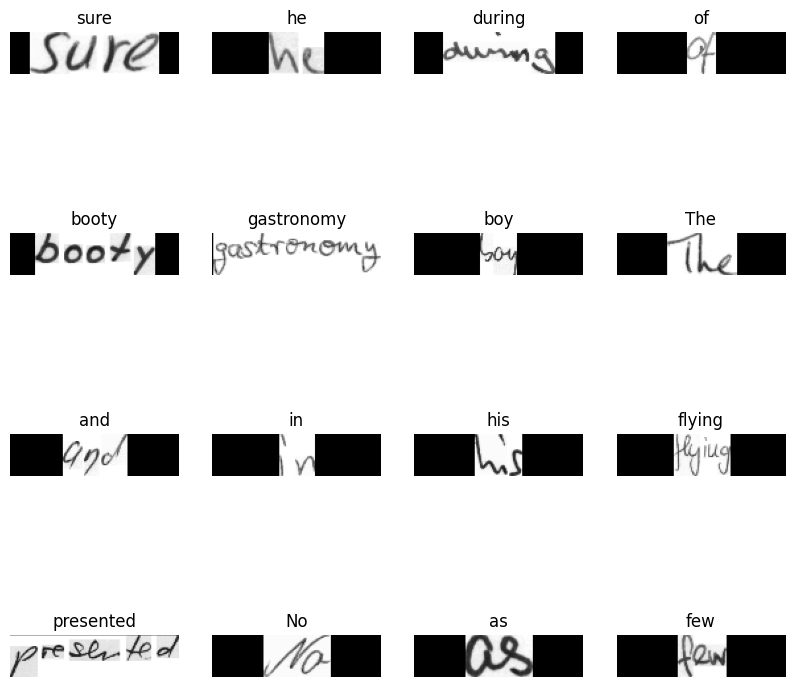

In [22]:
for data in train_ds.take(1):
    images, labels = data['image'], data['label']
    _, ax = plt.subplots(4, 4, figsize=(10, 10))
    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().astype(np.uint8)
        img = img[:, :, 0]

        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))

        label_text = tf.strings.reduce_join(num_to_char(indices)).numpy()
        label_text = label_text.decode('utf-8')

        ax[i // 4, i % 4].imshow(img, cmap='gray')
        ax[i // 4, i % 4].set_title(label_text)
        ax[i // 4, i % 4].axis('off')
plt.show()

In [23]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self,y_true,y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

def buildModel():
  input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
  labels = keras.layers.Input(name="label", shape=(None,))

  x = keras.layers.convo2D(32, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv1")(input_img)
  x = keras.layers.MaxPooling2D((2,2),name="pool1")(x)

  x = keras.layers.convo2D(64, (3, 3), activation="relu", kernel_initializer="he_normal", padding="same", name="Conv2")(input_img)
  x = keras.layers.MaxPooling2D((2,2),name="pool2")(x)

  new_shape = ((image_width // 4), (image_height // 4) * 64)
  x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
  x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

  x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="dense2")(x)
  output = CTCLayer(name="ctc_loss")(labels, x)

  model = keras.models.Model(inputs=[input_img, labels], outputs=output, name="handwritting-recognition")

  opt = keras.optimizers.Adam()
  model.compile(optimizer=opt)
  return model

model = buildModel()
model.summary()

AttributeError: module 'tensorflow.keras.layers' has no attribute 'convo2D'